In [252]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import newton

from CurveDataFetcher import CurveDataFetcher 
from CurveBuilder import get_spot_rates_bootstrapper, ql_piecewise_method_pretty
from CurveInterpolator import GeneralCurveInterpolator

from models.calibrate import (
    calibrate_ns_ols,
    calibrate_nss_ols,
    calibrate_mles_ols,
)

import nest_asyncio
nest_asyncio.apply()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [253]:
curve_data_fetcher = CurveDataFetcher(use_ust_issue_date=True)

# Curveset Filtering Strategies: 

## Using Only the On-The-Runs (Most recently issued):
- Ignoring any liquidty premium
- US Treasury's CMT Rates are derived from just OTRs

In [254]:
as_of_date = datetime(2024, 9, 6)
quote_type = "eod"

curve_set_otr_df = curve_data_fetcher.build_curve_set(
    as_of_date=as_of_date,
    sorted=True, 
    use_github=True,
    include_off_the_run_number=True,
    market_cols_to_return=[f"{quote_type}_price", f"{quote_type}_yield"],
)

curve_set_otr_df = curve_set_otr_df[curve_set_otr_df["is_on_the_run"]]
curve_set_otr_df

,cusip,security_type,auction_date,issue_date,maturity_date,time_to_maturity,int_rate,high_investment_rate,is_on_the_run,label,security_term,original_security_term,eod_price,eod_yield,rank
3,912797LK1,Bill,2024-08-29,2024-09-03,2024-10-01,0.068493,NaN,5.263000,True,"Oct 24s, 17-Week",4-Week,17-Week,99.690167,5.229702,13.0
7,912797LV7,Bill,2024-08-29,2024-09-03,2024-10-29,0.145205,NaN,5.212000,True,"Oct 24s, 17-Week",8-Week,17-Week,99.300000,5.208689,9.0
16,912797MR5,Bill,2024-08-28,2024-09-03,2024-12-31,0.317808,NaN,5.018000,True,"Dec 24s, 17-Week",17-Week,17-Week,98.477639,5.058823,0.0
26,912797LF2,Bill,2024-09-03,2024-09-05,2024-12-05,0.246575,NaN,5.103000,True,"Dec 24s, 26-Week",13-Week,26-Week,98.808583,5.106364,10.0
36,912797MM6,Bill,2024-09-03,2024-09-05,2025-03-06,0.495890,NaN,4.823000,True,"Mar 25s, 26-Week",26-Week,26-Week,97.745333,4.692008,0.0
49,912797MH7,Bill,2024-09-03,2024-09-05,2025-09-04,0.994521,NaN,4.345000,True,"Sep 25s, 52-Week",52-Week,52-Week,96.070000,4.107064,0.0
73,91282CLH2,Note,2024-08-27,2024-09-03,2026-08-31,1.983562,3.750,NaN,True,"Aug 26s, 2-Year",2-Year,2-Year,100.156250,3.666715,0.0
109,91282CLG4,Note,2024-08-06,2024-08-15,2027-08-15,2.939726,3.750,NaN,True,"Aug 27s, 3-Year",3-Year,3-Year,100.562500,3.544962,0.0
168,91282CLK5,Note,2024-08-28,2024-09-03,2029-08-31,4.986301,3.625,NaN,True,"Aug 29s, 5-Year",5-Year,5-Year,100.562500,3.500610,0.0
252,91282CLJ8,Note,2024-08-29,2024-09-03,2031-08-31,6.986301,3.750,NaN,True,"Aug 31s, 7-Year",7-Year,7-Year,100.906250,3.601744,0.0


## Liquidity Premium Filtering
- Practical for RV/Par Curve Builds
- Explored in Gurkaynak, Sack, Wright 2006, [Paper](https://www.federalreserve.gov/pubs/feds/2006/200628/200628abs.html)
- Most Sell Side Rate Strategy Teams employ some kind of liquidity premium filtering for zero curve estimation/par curve construction
- General Method:
  - Remove On-The-Runs, First Off-the-runs, Double olds (Some discretion with specifc maturity buckets)
  - Remove TBills (and/or CUSIPs with time to maturity less than x-years - can use GC repo/other MM rate for short end construction)
  - Remove CTDs
  - Remove CUSIPs trading significantly special in repo (JPM excludes securities with 6-month repo rates that are 25bp or more below 6-month GC repo rates)
  - Remove low free float CUSIPs (from JPM, free float = amount issued less SOMA ownership and bonds held in stripped form - $5bn or less)

- Specifc numbers up to your discretion

In [256]:
as_of_date = datetime(2024, 9, 6)
quote_type = "eod"

curve_set_filtered_df = curve_data_fetcher.build_curve_set(
    as_of_date=as_of_date,
    sorted=True,
    use_github=True,
    include_off_the_run_number=True,
    market_cols_to_return=[f"{quote_type}_price", f"{quote_type}_yield"],
    calc_free_float=True,
)

# remove OTRs and first off the runs, double olds
curve_set_filtered_df = curve_set_filtered_df[
    (curve_set_filtered_df["rank"] != 0)
    & (curve_set_filtered_df["rank"] != 1)
    # & (curve_set_filtered_df["rank"] != 2)
]

# remove TBills
curve_set_filtered_df = curve_set_filtered_df[
    curve_set_filtered_df["security_type"] != "Bill"
]

# remove low free float bonds (< $8bn)
curve_set_filtered_df = curve_set_filtered_df[
    curve_set_filtered_df["free_float"] > 5000
]

# filter out bonds very close to maturity
curve_set_filtered_df = curve_set_filtered_df[
    curve_set_filtered_df["time_to_maturity"] > 30 / 360
]

# remove CTDs (this is a TODO)
# curve_set_filtered_df = curve_set_filtered_df[curve_set_filtered_df["is_ctd"] == False]

# remove cusips trading special in repo (this is a TODO)
# curve_set_filtered_df = curve_set_filtered_df[curve_set_filtered_df["is_trading_special"] == False]

curve_set_filtered_df = curve_set_filtered_df.sort_values(by=["time_to_maturity"])

curve_set_filtered_df

Using SOMA Holdings Data As of 2024-09-04
Using STRIPping Data As of 2024-08-31 00:00:00


,cusip,security_type,auction_date,issue_date,maturity_date,time_to_maturity,int_rate,high_investment_rate,is_on_the_run,label,...,parValue,percentOutstanding,est_outstanding_amt,corpus_cusip,outstanding_amt,portion_unstripped_amt,portion_stripped_amt,reconstituted_amt,free_float,rank
75,91282CDB4,Note,2021-10-12,2021-10-15,2024-10-15,0.106849,0.625,NaN,False,"Oct 24s, 3-Year",...,4.364017e+09,0.069976,6.236404e+10,912821GN9,6.236404e+10,62330444.4,3.360000e+07,0.0,57966.4277,34.0
51,91282CFQ9,Note,2022-10-25,2022-10-31,2024-10-31,0.150685,4.375,NaN,False,"Oct 24s, 2-Year",...,0.000000e+00,NaN,NaN,912821JY2,4.199464e+10,41963280.8,3.136000e+07,0.0,41963.2808,22.0
170,9128283D0,Note,2017-10-26,2017-10-31,2024-10-31,0.150685,2.250,NaN,False,"Oct 24s, 7-Year",...,6.865383e+09,0.239208,2.870049e+10,9128203U9,2.870049e+10,28687689.9,1.280000e+07,0.0,21822.3065,82.0
111,912828YM6,Note,2019-10-23,2019-10-31,2024-10-31,0.150685,1.500,NaN,False,"Oct 24s, 5-Year",...,1.536157e+10,0.339207,4.528664e+10,912821DC6,4.528664e+10,45235441.2,5.120000e+07,0.0,29873.8744,57.0
76,91282CDH1,Note,2021-11-08,2021-11-15,2024-11-15,0.191781,0.750,NaN,False,"Nov 24s, 3-Year",...,3.476853e+10,0.393338,8.839359e+10,912821GT6,8.839359e+10,88372791.6,2.080000e+07,0.0,53604.2648,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,912810TN8,Bond,2023-04-13,2023-04-17,2053-02-15,28.463014,3.625,NaN,False,"Feb 53s, 30-Year",...,9.367420e+09,0.141965,6.598403e+10,912803GP2,6.598403e+10,50776147.7,1.520788e+10,1928840.0,41408.7278,6.0
388,912810TR9,Bond,2023-07-13,2023-07-17,2053-05-15,28.706849,3.625,NaN,False,"May 53s, 30-Year",...,5.723292e+09,0.091437,6.259307e+10,912803GS6,6.259307e+10,39896116.8,2.269696e+10,5104270.0,34172.8249,5.0
389,912810TT5,Bond,2023-10-12,2023-10-16,2053-08-15,28.958904,4.125,NaN,False,"Aug 53s, 30-Year",...,8.606596e+09,0.120247,7.157430e+10,912803GU1,7.157430e+10,60954881.0,1.061942e+10,991450.0,52348.2848,4.0
390,912810TV0,Bond,2024-01-11,2024-01-16,2053-11-15,29.210959,4.750,NaN,False,"Nov 53s, 30-Year",...,4.567153e+08,0.006874,6.644364e+10,912803GW7,6.644364e+10,56812091.9,9.631553e+09,1679110.0,56355.3766,3.0


## Using Market Observed Zero Rates (P-STRIPs, C-STRIPs, TBills)
- Explored in Brian Sack's [***Using Treasury STRIPS to Measure the Yield Curve***](https://www.federalreserve.gov/pubs/feds/2000/200042/200042pap.pdf)

**Note: We're using quotes observed from public.com so we don't have much historical data**

### Market Observed YTMs from P-STRIPs:

In [24]:
as_of_date = datetime(2024, 9, 6)

curve_set_strips_df = curve_data_fetcher.build_curve_set(
    as_of_date=as_of_date,
    sorted=True, 
    use_github=True, 
    include_corpus_cusip=True,
)

In [22]:
pstrips_dict_df = curve_data_fetcher.publicdotcom_data_fetcher.public_dotcom_timeseries_api(
    cusips=curve_set_strips_df[curve_set_strips_df["security_type"] != "Bill"][
        "corpus_cusip"
    ].to_list(),
    start_date=as_of_date,
    end_date=as_of_date,
)
pstrips_quotes_df = pd.DataFrame(
    [
        {
            "corpus_cusip": cusip,
            "pstrip_price": df.iloc[-1]["Price"],
            "pstrip_ytm": df.iloc[-1]["YTM"],
        }
        for cusip, df in pstrips_dict_df.items()
        if not df.empty
    ]
)
pstrips_quotes_df = pd.merge(
    curve_set_strips_df[
        [
            "cusip",
            "label",
            "issue_date",
            "maturity_date",
            "time_to_maturity",
            "corpus_cusip",
        ]
    ],
    right=pstrips_quotes_df,
    on="corpus_cusip",
)

pstrips_quotes_df

,cusip,label,issue_date,maturity_date,time_to_maturity,corpus_cusip,pstrip_price,pstrip_ytm
0,91282CFN6,"Sep 24s, 2-Year",2022-09-30,2024-09-30,0.065753,912821JT3,99.7232,4.836810
1,91282CFQ9,"Oct 24s, 2-Year",2022-10-31,2024-10-31,0.150685,912821JY2,99.3730,4.440975
2,91282CFX4,"Nov 24s, 2-Year",2022-11-30,2024-11-30,0.232877,912821KD6,99.0329,4.358277
3,91282CGD7,"Dec 24s, 2-Year",2023-01-03,2024-12-31,0.317808,912821KH7,98.6974,4.274635
4,91282CGG0,"Jan 25s, 2-Year",2023-01-31,2025-01-31,0.402740,912821KN4,98.3607,4.235818
...,...,...,...,...,...,...,...,...
211,912810SX7,"May 51s, 30-Year",2021-07-15,2051-05-15,26.704110,912803FY4,33.4793,4.186718
212,912810SZ2,"Aug 51s, 30-Year",2021-10-15,2051-08-15,26.956164,912803GA5,33.2173,4.177119
213,912810TD0,"Feb 52s, 30-Year",2022-04-18,2052-02-15,27.460274,912803GE7,32.7411,4.153793
214,912810TJ7,"Aug 52s, 30-Year",2022-10-17,2052-08-15,27.958904,912803GK3,32.3460,4.123642


### Market Observed YTMs from C-STRIPs:

In [23]:
cstrips_curve_set_df = pd.read_excel(r"C:\Users\chris\Curvy-CUSIPs\data\cstrips_info.xlsx")
cstrips_curve_set_df["time_to_maturity"] = (cstrips_curve_set_df["maturity_date"] - as_of_date).dt.days / 365

cstrips_dict_df = curve_data_fetcher.publicdotcom_data_fetcher.public_dotcom_timeseries_api(
    cusips=cstrips_curve_set_df["cusip"].to_list(),
    start_date=as_of_date,
    end_date=as_of_date,
    max_concurrent_tasks=64,
)
cstrips_quotes_df = pd.DataFrame(
    [
        {
            "cusip": cusip,
            "cstrip_price": df.iloc[-1]["Price"],
            "cstrip_ytm": df.iloc[-1]["YTM"],
        }
        for cusip, df in cstrips_dict_df.items()
        if not df.empty
    ]
)
cstrips_quotes_df = pd.merge(
    cstrips_curve_set_df[
        [
            "cusip",
            "label",
            "maturity_date",
            "time_to_maturity",
        ]
    ],
    right=cstrips_quotes_df,
    on="cusip",
)

cstrips_quotes_df

,cusip,label,maturity_date,time_to_maturity,cstrip_price,cstrip_ytm
0,912833LT5,"Nov 24, UST STRIPPED INT PMT",2024-11-15,0.191781,99.1290,4.799552
1,912833LU2,"Feb 25, UST STRIPPED INT PMT",2025-02-15,0.443836,98.2124,4.189786
2,912833LV0,"May 25, UST STRIPPED INT PMT",2025-05-15,0.687671,97.1437,4.327376
3,912833LW8,"Aug 25, UST STRIPPED INT PMT",2025-08-15,0.939726,96.3676,4.046481
4,912833LX6,"Nov 25, UST STRIPPED INT PMT",2025-11-15,1.191781,95.4507,4.014019
...,...,...,...,...,...,...
111,912834D47,"Aug 52, UST STRIPPED INT PMT",2052-08-15,27.958904,31.4954,4.223035
112,912834F29,"Nov 52, UST STRIPPED INT PMT",2052-11-15,28.210959,31.6231,4.169601
113,912834G93,"May 53, UST STRIPPED INT PMT",2053-05-15,28.706849,31.2800,4.135587
114,912834H84,"Aug 53, UST STRIPPED INT PMT",2053-08-15,28.958904,31.1858,4.109667


### Market Observed YTMs from TBills:

In [25]:
tbill_curve_set_df = curve_set_strips_df[
    (curve_set_strips_df["security_type"] == "Bill")
    & (curve_set_strips_df["time_to_maturity"] > 1 / 360)
]

tbill_quotes = (
    curve_data_fetcher.publicdotcom_data_fetcher.public_dotcom_timeseries_api(
        cusips=tbill_curve_set_df["cusip"].to_list(),
        start_date=as_of_date,
        end_date=as_of_date,
    )
)

tbill_quotes_df = pd.DataFrame(
    [
        {
            "cusip": cusip,
            "tbill_price": df.iloc[-1]["Price"],
            "tbill_ytm": df.iloc[-1]["YTM"],
        }
        for cusip, df in tbill_quotes.items()
        if not df.empty
    ]
)
tbill_quotes_df = pd.merge(
    tbill_curve_set_df[
        [
            "cusip",
            "label",
            "maturity_date",
            "time_to_maturity",
        ]
    ],
    right=tbill_quotes_df,
    on="cusip",
)

tbill_quotes_df

,cusip,label,maturity_date,time_to_maturity,tbill_price,tbill_ytm
0,912797LG0,"Sep 24s, 17-Week",2024-09-10,0.010959,99.9845,5.569239
1,912797LH8,"Sep 24s, 17-Week",2024-09-17,0.030137,99.8762,5.569239
2,912797LJ4,"Sep 24s, 17-Week",2024-09-24,0.049315,99.7679,5.569239
3,912797LK1,"Oct 24s, 17-Week",2024-10-01,0.068493,99.6414,5.867168
4,912797LS4,"Oct 24s, 17-Week",2024-10-08,0.087671,99.5462,5.633357
5,912797LT2,"Oct 24s, 17-Week",2024-10-15,0.106849,99.4516,5.483967
6,912797LU9,"Oct 24s, 17-Week",2024-10-22,0.126027,99.3561,5.390757
7,912797LV7,"Oct 24s, 17-Week",2024-10-29,0.145205,99.2687,5.264852
8,912797MA2,"Nov 24s, 17-Week",2024-11-05,0.164384,99.1729,5.223508
9,912797MB0,"Nov 24s, 17-Week",2024-11-12,0.183562,99.0819,5.163831


# Curve Construction Strategies - To Bootstrap or to Interpolate???

## Zero Curve Estimation: Quantlib Bootstrapping + Interpolation on OTR Curveset

In [36]:
bs_methods = [
    "ql_plld", # PiecewiseLogLinearDiscount
    "ql_lz", # Piecewise Linear Zero
    "ql_spd", # PiecewiseSplineCubicDiscount
    "ql_mcf", # PiecewiseConvexMonotoneForward 
    "ql_mlpcd", # PiecewiseMonotonicLogParabolicCubicDiscount
    "ql_f_nss", # SvenssonFitting
]
cc_spot_rates_dict = get_spot_rates_bootstrapper(
    curve_set_df=curve_set_otr_df,
    as_of_date=as_of_date,
    on_rate=5.31,
    ql_bootstrap_interp_methods=bs_methods,
    interpolated_months_num=361,
    return_ql_zero_curve=True,
    # daily_interpolation=True,
    return_scipy_interp_func=True,
    continuous_compounded_zero=True
)

cc_spot_rates_dict["spot_rate_df"]

Get Spot Rates - multiple bs methods passed - returning ql zero curve based on first bs method


,maturity_date,time_to_maturity,ql_plld_spot_rate,ql_lz_spot_rate,ql_spd_spot_rate,ql_mcf_spot_rate,ql_mlpcd_spot_rate,ql_f_nss_spot_rate,avg_spot_rate
0,2024-09-06,0.002778,5.310000,5.310000,5.310000,5.310000,5.310000,5.310000,5.310000
1,2024-10-09,0.083333,5.152305,5.156280,5.162851,5.158794,5.160618,5.220403,5.168542
2,2024-11-12,0.166667,5.099722,5.112362,5.115165,5.114881,5.114881,5.089772,5.107797
3,2024-12-09,0.250000,5.026552,5.029542,5.030559,5.030182,5.030182,4.967145,5.019027
4,2025-01-09,0.333333,4.911415,4.929492,4.935507,4.933900,4.933900,4.852082,4.916049
...,...,...,...,...,...,...,...,...,...
356,2054-05-11,29.666667,4.016187,4.025246,4.011236,4.011431,4.010840,4.133330,4.034712
357,2054-06-09,29.750000,4.015339,4.023912,4.009518,4.009877,4.008661,4.133862,4.033528
358,2054-07-09,29.833333,4.014496,4.022579,4.007833,4.008330,4.006471,4.134391,4.032350
359,2054-08-10,29.916667,4.013657,4.021246,4.006184,4.006792,4.004273,4.134917,4.031178


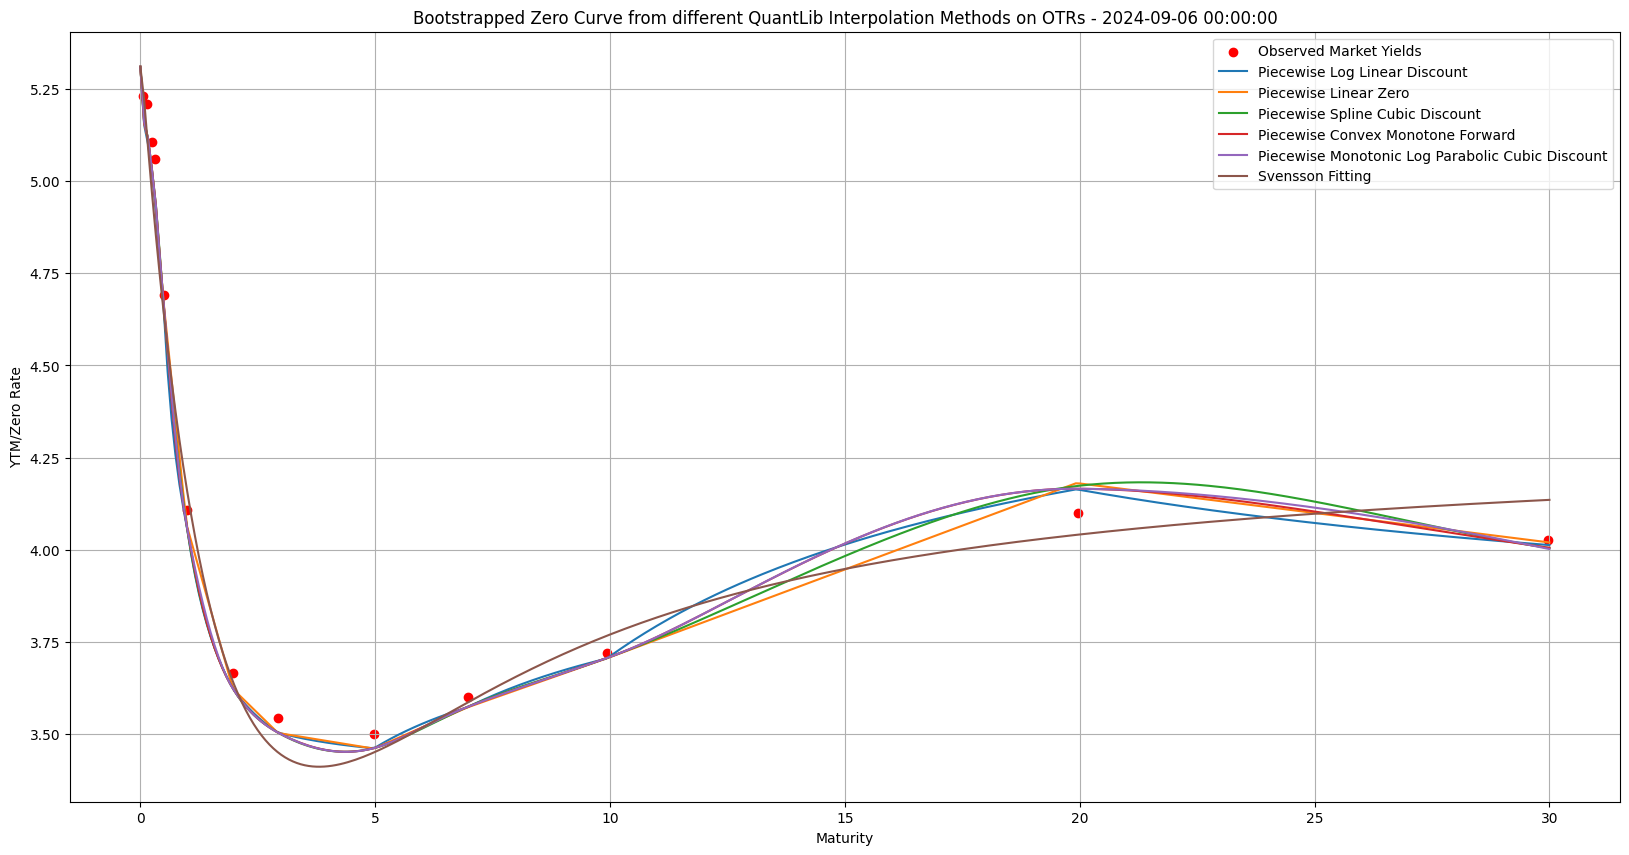

In [116]:
plt.figure(figsize=(20, 10))
plt.scatter(
    curve_set_otr_df["time_to_maturity"],
    curve_set_otr_df[f"{quote_type}_yield"],
    color="red",
    label="Observed Market Yields",
)

for bs_method in bs_methods:
    plt.plot(
        cc_spot_rates_dict["spot_rate_df"]["time_to_maturity"],
        cc_spot_rates_dict["spot_rate_df"][f"{bs_method}_spot_rate"],
        label=f"{ql_piecewise_method_pretty(bs_method)}",
    )

plt.title(
    f"Bootstrapped Zero Curve from different QuantLib Interpolation Methods on OTRs - {as_of_date}"
)
plt.xlabel("Maturity")
plt.ylabel("YTM/Zero Rate")
plt.legend()
plt.grid(True)
plt.show()

## Using Parametric Models for Curve Construction/Zero Curve Estimation:

In [263]:
def parametric_zero_curve_plot(curve_set_df: pd.DataFrame, title: str, ytm_col=f"{quote_type}_yield"):
    plt.figure(figsize=(20, 10))
    plt.scatter(
        curve_set_df["time_to_maturity"],
        curve_set_df[ytm_col],
        color="black",
        label="Observed Market Yields",
    )

    ttm_ls = np.linspace(0, 30, 1000)

    ns_func, status_ns = calibrate_ns_ols(
        curve_set_df["time_to_maturity"].to_numpy(),
        curve_set_df[ytm_col].to_numpy(),
    )
    assert status_ns
    plt.plot(
        ttm_ls,
        ns_func(ttm_ls),
        label="Zero Curve - Nelson-Siegel OLS-Based-Calibration",
    )

    nss_func, status_nss, _ = calibrate_nss_ols(
        curve_set_df["time_to_maturity"].to_numpy(),
        curve_set_df[ytm_col].to_numpy(),
    )
    assert status_nss
    plt.plot(
        ttm_ls,
        nss_func(ttm_ls),
        label="Zero Curve - Nelson-Siegel-Svensson OLS-Based-Calibration",
    )

    mles_func, status_mles = calibrate_mles_ols(
        curve_set_df["time_to_maturity"].to_numpy(),
        curve_set_df[ytm_col].to_numpy(),
        overnight_rate=5.31,
        N=9,
    )
    assert status_mles
    plt.plot(
        ttm_ls,
        mles_func(ttm_ls),
        label="Zero Curve - Merrill Lynch Exponential Spline OLS-Based-Calibration",
    )

    plt.title(title)
    plt.xlabel("Maturity")
    plt.ylabel("YTM/Zero Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

c:\Users\chris\Curvy-CUSIPs\models\MLESM.py:47: RuntimeWarning: divide by zero encountered in divide
  return -np.log(prices) / maturities * 100


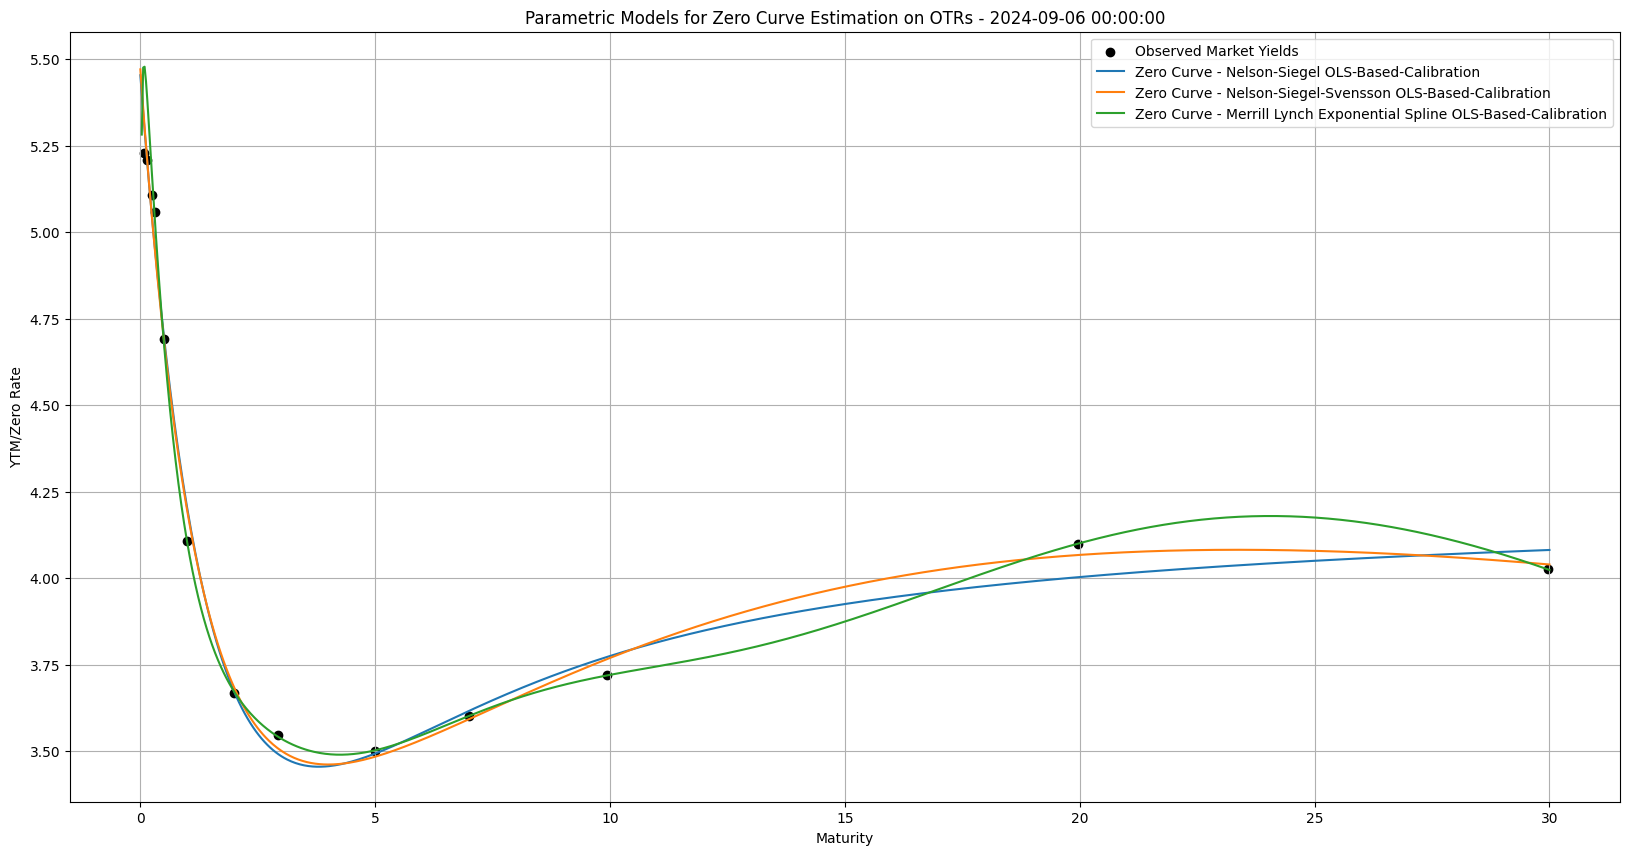

In [264]:
parametric_zero_curve_plot(curve_set_df=curve_set_otr_df, title=f"Parametric Models for Zero Curve Estimation on OTRs - {as_of_date}")

c:\Users\chris\Curvy-CUSIPs\models\MLESM.py:47: RuntimeWarning: divide by zero encountered in divide
  return -np.log(prices) / maturities * 100


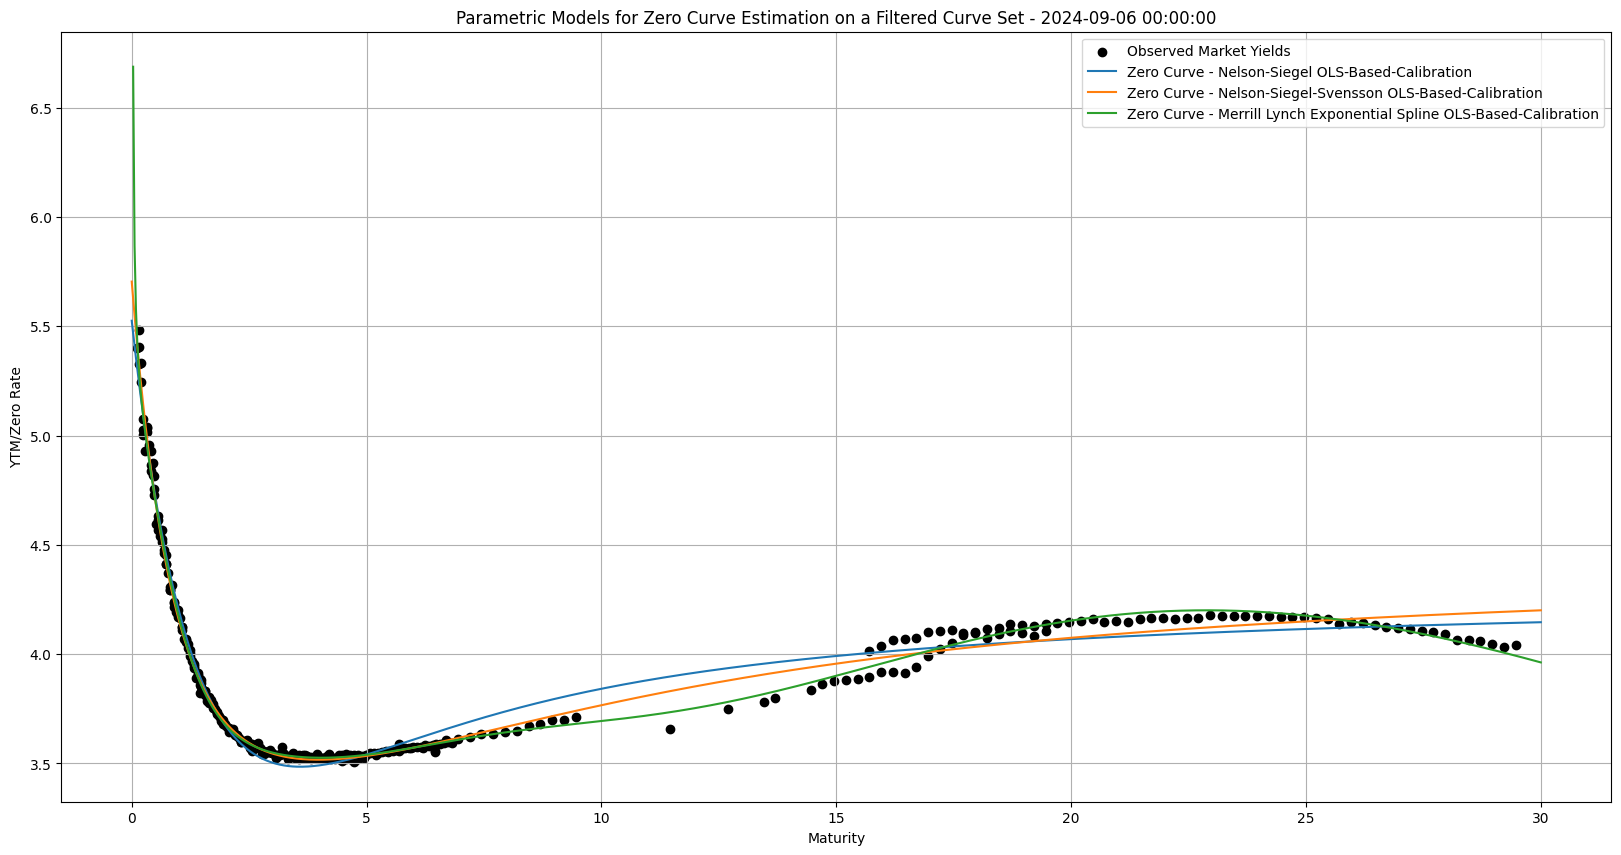

In [265]:
parametric_zero_curve_plot(curve_set_df=curve_set_filtered_df, title=f"Parametric Models for Zero Curve Estimation on a Filtered Curve Set - {as_of_date}")

## Using Splines/Interpolation Methods for Curve Construction:

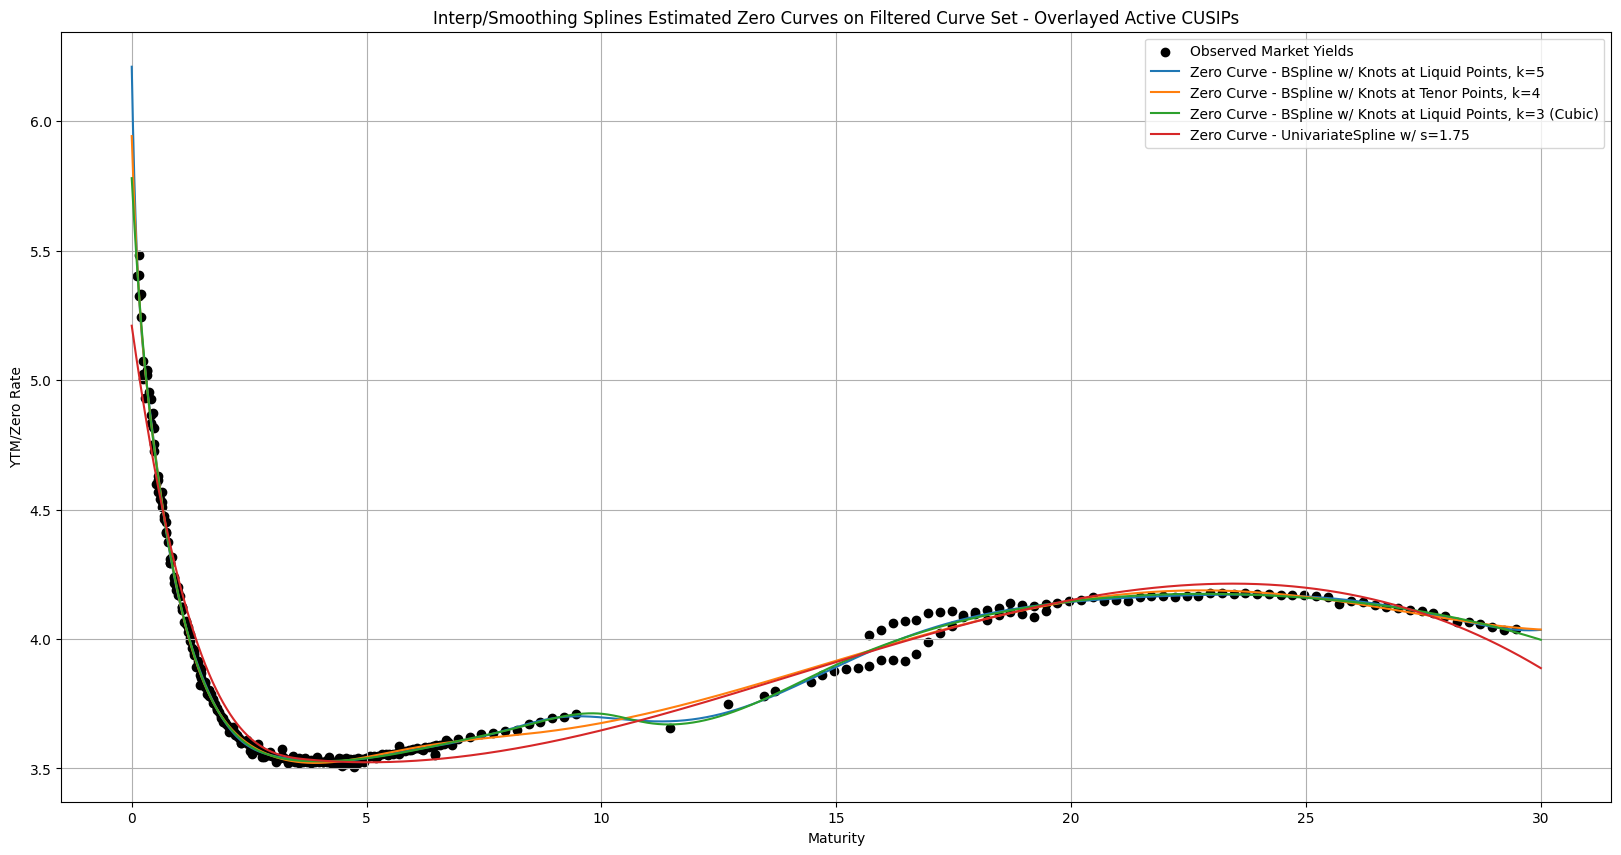

In [257]:
plt.figure(figsize=(20, 10))
plt.scatter(
    curve_set_filtered_df["time_to_maturity"],
    curve_set_filtered_df[f"{quote_type}_yield"],
    label="Observed Market Yields",
    color="black",
)

ttm_ls = np.linspace(0, 30, 10000)

curve_interpolater = GeneralCurveInterpolator(
    x=curve_set_filtered_df["time_to_maturity"].to_numpy(),
    y=curve_set_filtered_df[f"{quote_type}_yield"].to_numpy(),
)
bspline_func1 = curve_interpolater.b_spline_with_knots_interpolation(
    knots=[0.5, 1, 2, 3, 4, 5, 7, 8, 9, 10, 15, 20, 25], k=5, return_func=True
)
bspline_func2 = curve_interpolater.b_spline_with_knots_interpolation(
    knots=[0.5, 1, 2, 3, 5, 7, 10, 20], k=4, return_func=True
)
bspline_func3 = curve_interpolater.b_spline_with_knots_interpolation(
    knots=[0.5, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 20, 25], k=3, return_func=True
)

plt.plot(
    ttm_ls,
    bspline_func1(ttm_ls),
    label="Zero Curve - BSpline w/ Knots at Liquid Points, k=5",
)
plt.plot(
    ttm_ls,
    bspline_func2(ttm_ls),
    label="Zero Curve - BSpline w/ Knots at Tenor Points, k=4",
)
plt.plot(
    ttm_ls,
    bspline_func3(ttm_ls),
    label="Zero Curve - BSpline w/ Knots at Liquid Points, k=3 (Cubic)",
)
s = 1.75
plt.plot(
    ttm_ls,
    curve_interpolater.univariate_spline(s=s, return_func=True)(ttm_ls),
    label=f"Zero Curve - UnivariateSpline w/ s={s}",
)


plt.title("Interp/Smoothing Splines Estimated Zero Curves on Filtered Curve Set - Overlayed Active CUSIPs")
plt.xlabel("Maturity")
plt.ylabel("YTM/Zero Rate")
plt.legend()
plt.grid(True)
plt.show()

In [258]:
# splines assume that function is well-defined
# duplicate x values with different y-values breaks the assumption of a well-defined function
# we weight market observed ytms by their free float
# allows us to use more interpolation methods

free_float_weighted_curve_set_df = (
    curve_set_filtered_df.groupby("time_to_maturity")
    .apply(
        lambda x: (x[f"{quote_type}_yield"] * x["free_float"]).sum()
        / x["free_float"].sum(), include_groups=False
    )
    .reset_index(name="free_float_weighted_ytm")
)
free_float_weighted_curve_set_df

,time_to_maturity,free_float_weighted_ytm
0,0.106849,5.402387
1,0.150685,5.411030
2,0.191781,5.289233
3,0.232877,5.027462
4,0.273973,4.930368
...,...,...
201,28.463014,4.066580
202,28.706849,4.058285
203,28.958904,4.047313
204,29.210959,4.033243


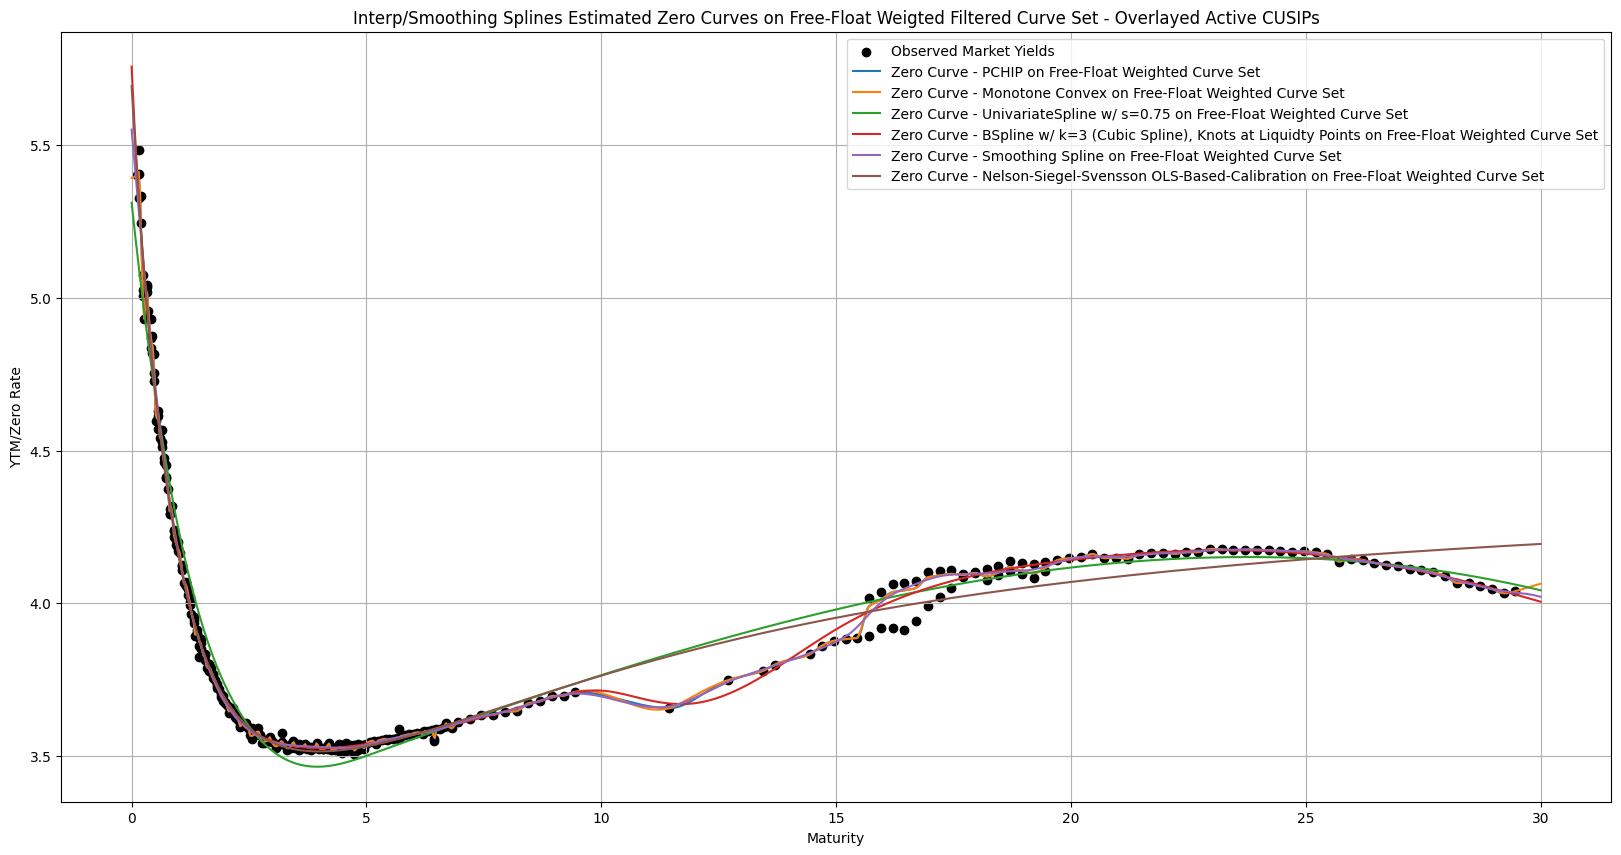

In [259]:
plt.figure(figsize=(20, 10))
plt.scatter(
    curve_set_filtered_df["time_to_maturity"],
    curve_set_filtered_df[f"{quote_type}_yield"],
    label="Observed Market Yields",
    color="black",
)

ttm_ls = np.linspace(0, 30, 1000)

# interpolations
float_weighted_curve_interpolater = GeneralCurveInterpolator(
    x=free_float_weighted_curve_set_df["time_to_maturity"].to_numpy(),
    y=free_float_weighted_curve_set_df["free_float_weighted_ytm"].to_numpy(),
)
plt.plot(
    ttm_ls,
    float_weighted_curve_interpolater.pchip_interpolation(return_func=True)(ttm_ls),
    label="Zero Curve - PCHIP on Free-Float Weighted Curve Set",
)

plt.plot(
    ttm_ls,
    float_weighted_curve_interpolater.monotone_convex()(ttm_ls),
    label="Zero Curve - Monotone Convex on Free-Float Weighted Curve Set",
)

# smooth splines
s = 0.75
plt.plot(
    ttm_ls,
    float_weighted_curve_interpolater.univariate_spline(s=s, return_func=True)(ttm_ls),
    label=f"Zero Curve - UnivariateSpline w/ s={s} on Free-Float Weighted Curve Set",
)

plt.plot(
    ttm_ls,
    float_weighted_curve_interpolater.b_spline_with_knots_interpolation(
        knots=[0.5, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 15, 20, 25], k=3, return_func=True
    )(ttm_ls),
    label=f"Zero Curve - BSpline w/ k=3 (Cubic Spline), Knots at Liquidty Points on Free-Float Weighted Curve Set",
)

plt.plot(
    ttm_ls,
    float_weighted_curve_interpolater.smoothing_spline()(ttm_ls),
    label=f"Zero Curve - Smoothing Spline on Free-Float Weighted Curve Set",
)

# parametric model
nss_func, status_nss, _ = calibrate_nss_ols(
    free_float_weighted_curve_set_df["time_to_maturity"].to_numpy(),
    free_float_weighted_curve_set_df["free_float_weighted_ytm"].to_numpy(),
)
assert status_nss
plt.plot(
    ttm_ls,
    nss_func(ttm_ls),
    label="Zero Curve - Nelson-Siegel-Svensson OLS-Based-Calibration on Free-Float Weighted Curve Set",
)

plt.title("Interp/Smoothing Splines Estimated Zero Curves on Free-Float Weigted Filtered Curve Set - Overlayed Active CUSIPs")
plt.xlabel("Maturity")
plt.ylabel("YTM/Zero Rate")
plt.legend()
plt.grid(True)
plt.show()

## Par Curve from Estimated Zero Curves

In [260]:
def par_bond_equation(c, maturity, zero_curve_func):
    discounted_cash_flows = sum(
        (c / 2) * np.exp(-(zero_curve_func(t) / 100) * t)
        for t in np.arange(0.5, maturity + 0.5, 0.5)
    )
    final_payment = 100 * np.exp(-(zero_curve_func(maturity) / 100) * maturity)
    return discounted_cash_flows + final_payment - 100

def par_curve_func(tenor, zero_curve_func):
    init_guess = 4
    return newton(par_bond_equation, x0=init_guess, args=(tenor, zero_curve_func))

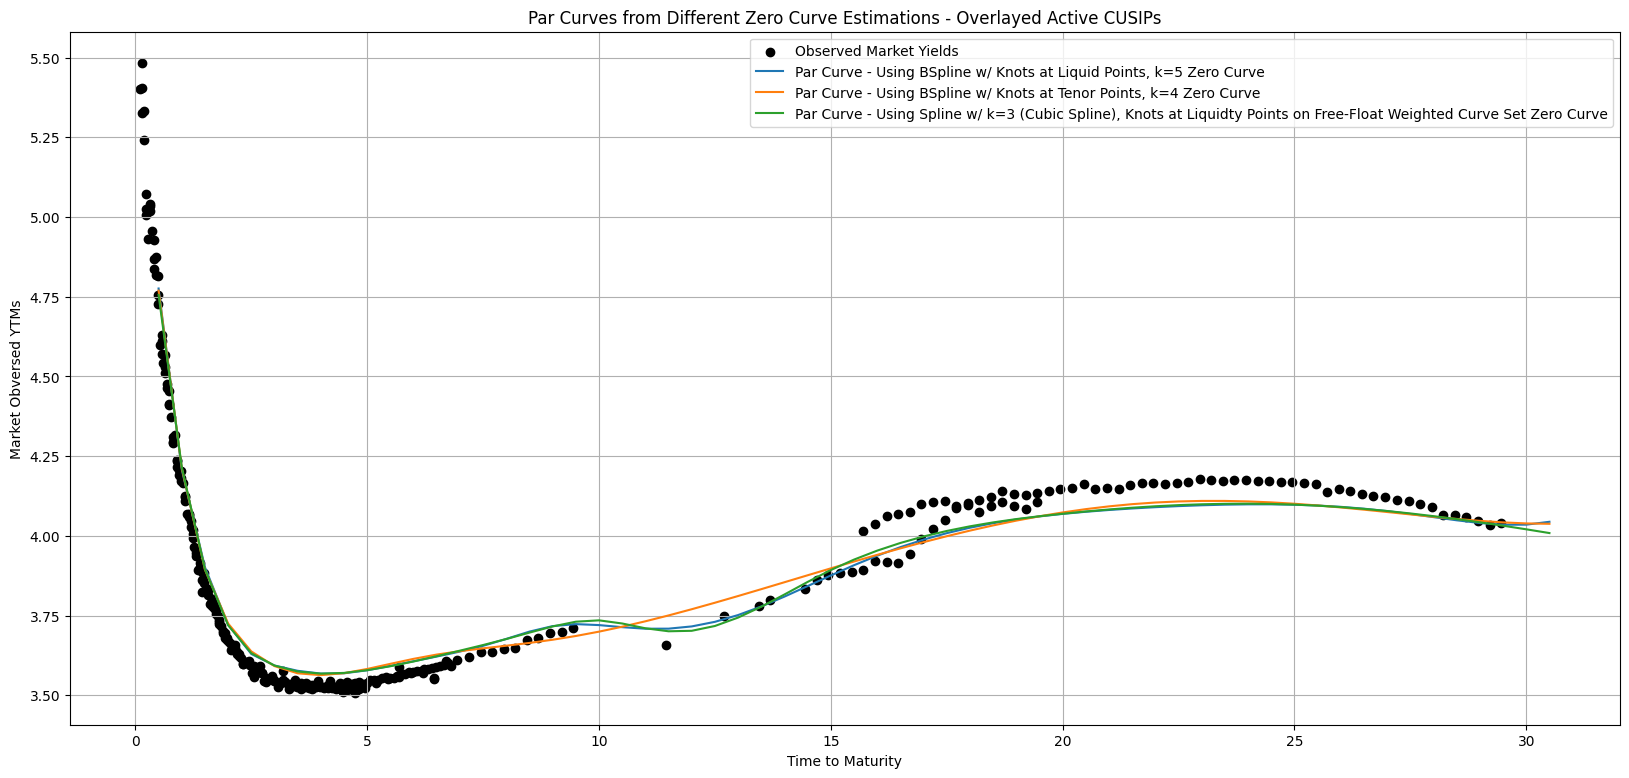

In [262]:
plt.figure(figsize=(20, 9))
plt.scatter(
    curve_set_filtered_df["time_to_maturity"],
    curve_set_filtered_df[f"{quote_type}_yield"],
    color="black",
    label="Observed Market Yields",
)

t2 = np.arange(0.5, 30 + 1, 0.5)
plt.plot(
    t2,
    [par_curve_func(t, bspline_func1) for t in t2],
    label="Par Curve - Using BSpline w/ Knots at Liquid Points, k=5 Zero Curve",
)
plt.plot(
    t2,
    [par_curve_func(t, bspline_func2) for t in t2],
    label="Par Curve - Using BSpline w/ Knots at Tenor Points, k=4 Zero Curve",
)
plt.plot(
    t2,
    [
        par_curve_func(
            t,
            float_weighted_curve_interpolater.b_spline_with_knots_interpolation(
                knots=[0.5, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 15, 20, 25],
                k=3,
                return_func=True,
            ),
        )
        for t in t2
    ],
    label="Par Curve - Using Spline w/ k=3 (Cubic Spline), Knots at Liquidty Points on Free-Float Weighted Curve Set Zero Curve",
)


plt.xlabel("Time to Maturity")
plt.ylabel("Market Obversed YTMs")
plt.title("Par Curves from Different Zero Curve Estimations - Overlayed Active CUSIPs")
plt.legend()
plt.grid(True)
plt.show()

## Interpolating/Fitting on Market Observed Zeros (P-STRIPs, C-STRIPs, TBills):

In [223]:
# TBills and CSTRIPs
market_obs_zeros_cstrips_df = pd.concat(
    [
        tbill_quotes_df.rename(
            columns={"tbill_price": "obsv_price", "tbill_ytm": "obsv_ytm"}
        ),
        cstrips_quotes_df.rename(
            columns={"cstrip_price": "obsv_price", "cstrip_ytm": "obsv_ytm"}
        ),
    ]
)
market_obs_zeros_cstrips_df = market_obs_zeros_cstrips_df.sort_values(
    by=["time_to_maturity"]
).drop_duplicates(subset=["time_to_maturity"])

market_obs_zeros_cstrips_df

,cusip,label,maturity_date,time_to_maturity,obsv_price,obsv_ytm
0,912797LG0,"Sep 24s, 17-Week",2024-09-10,0.010959,99.9845,5.569239
14,912797KK2,"Sep 24s, 26-Week",2024-09-12,0.016438,99.9535,5.569239
1,912797LH8,"Sep 24s, 17-Week",2024-09-17,0.030137,99.8762,5.569239
15,912797KL0,"Sep 24s, 26-Week",2024-09-19,0.035616,99.8452,5.569239
2,912797LJ4,"Sep 24s, 17-Week",2024-09-24,0.049315,99.7679,5.569239
...,...,...,...,...,...,...
111,912834D47,"Aug 52, UST STRIPPED INT PMT",2052-08-15,27.958904,31.4954,4.223035
112,912834F29,"Nov 52, UST STRIPPED INT PMT",2052-11-15,28.210959,31.6231,4.169601
113,912834G93,"May 53, UST STRIPPED INT PMT",2053-05-15,28.706849,31.2800,4.135587
114,912834H84,"Aug 53, UST STRIPPED INT PMT",2053-08-15,28.958904,31.1858,4.109667


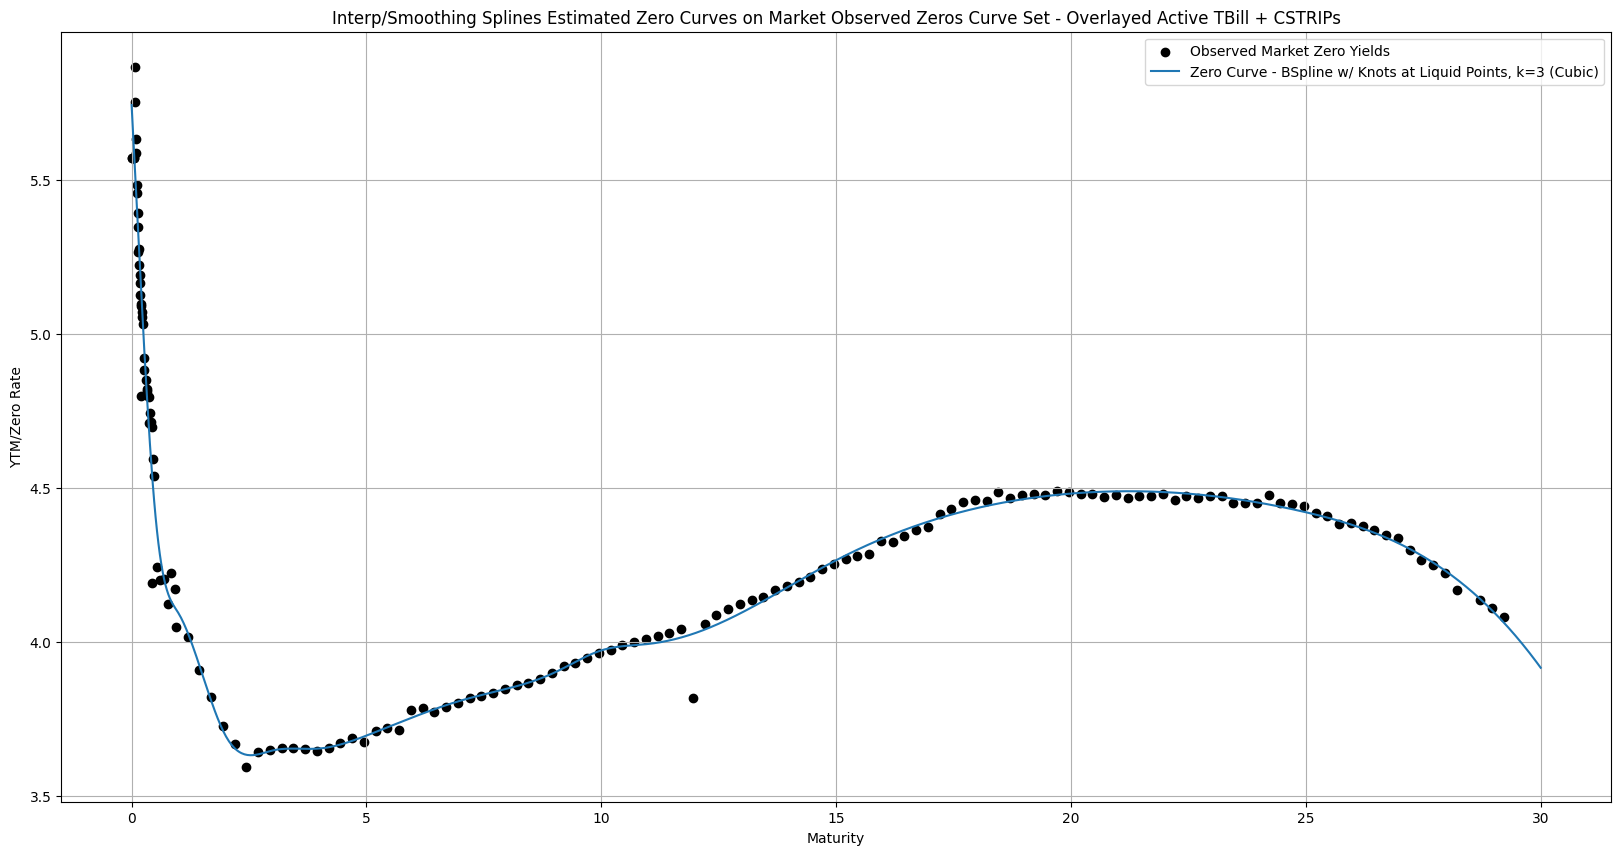

In [229]:
plt.figure(figsize=(20, 10))
plt.scatter(
    market_obs_zeros_cstrips_df["time_to_maturity"],
    market_obs_zeros_cstrips_df["obsv_ytm"],
    label="Observed Market Zero Yields",
    color="black",
)

ttm_ls = np.linspace(0, 30, 1000)

curve_interpolater = GeneralCurveInterpolator(
    x=market_obs_zeros_cstrips_df["time_to_maturity"].to_numpy(),
    y=market_obs_zeros_cstrips_df["obsv_ytm"].to_numpy(),
)

bspline_func3 = curve_interpolater.b_spline_with_knots_interpolation(
    knots=[0.5, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 20, 25], k=3, return_func=True
)

plt.plot(
    ttm_ls,
    bspline_func3(ttm_ls),
    label="Zero Curve - BSpline w/ Knots at Liquid Points, k=3 (Cubic)",
)

plt.title("Interp/Smoothing Splines Estimated Zero Curves on Market Observed Zeros Curve Set - Overlayed Active TBill + CSTRIPs")
plt.xlabel("Maturity")
plt.ylabel("YTM/Zero Rate")
plt.legend()
plt.grid(True)
plt.show()

In [224]:
# TBills and PSTRIPs
market_obs_zeros_pstrips_df = pd.concat(
    [
        tbill_quotes_df.rename(
            columns={"tbill_price": "obsv_price", "tbill_ytm": "obsv_ytm"}
        ),
        pstrips_quotes_df.rename(
            columns={"pstrip_price": "obsv_price", "pstrip_ytm": "obsv_ytm"}
        ),
    ]
)
market_obs_zeros_pstrips_df = market_obs_zeros_pstrips_df.sort_values(
    by=["time_to_maturity"]
).drop_duplicates(subset=["time_to_maturity"])

market_obs_zeros_pstrips_df

,cusip,label,maturity_date,time_to_maturity,obsv_price,obsv_ytm,issue_date,corpus_cusip
0,912797LG0,"Sep 24s, 17-Week",2024-09-10,0.010959,99.9845,5.569239,NaT,NaN
14,912797KK2,"Sep 24s, 26-Week",2024-09-12,0.016438,99.9535,5.569239,NaT,NaN
7,91282CCX7,"Sep 24s, 3-Year",2024-09-15,0.024658,99.8972,6.277389,2021-09-15,912821GJ8
1,912797LH8,"Sep 24s, 17-Week",2024-09-17,0.030137,99.8762,5.569239,NaT,NaN
15,912797KL0,"Sep 24s, 26-Week",2024-09-19,0.035616,99.8452,5.569239,NaT,NaN
...,...,...,...,...,...,...,...,...
211,912810SX7,"May 51s, 30-Year",2051-05-15,26.704110,33.4793,4.186718,2021-07-15,912803FY4
212,912810SZ2,"Aug 51s, 30-Year",2051-08-15,26.956164,33.2173,4.177119,2021-10-15,912803GA5
213,912810TD0,"Feb 52s, 30-Year",2052-02-15,27.460274,32.7411,4.153793,2022-04-18,912803GE7
214,912810TJ7,"Aug 52s, 30-Year",2052-08-15,27.958904,32.3460,4.123642,2022-10-17,912803GK3


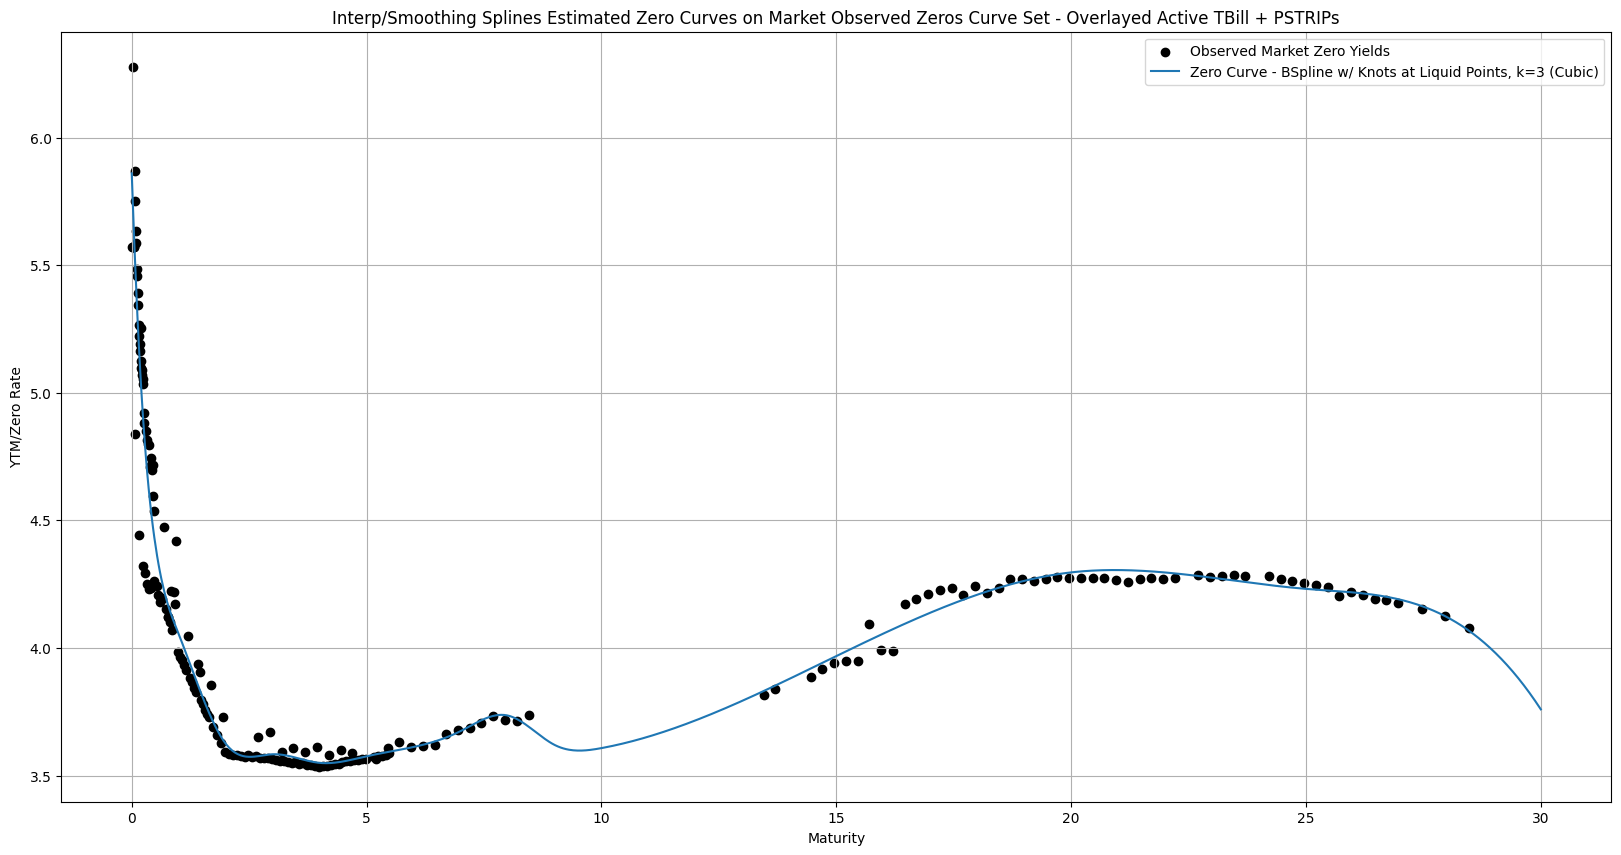

In [230]:
plt.figure(figsize=(20, 10))
plt.scatter(
    market_obs_zeros_pstrips_df["time_to_maturity"],
    market_obs_zeros_pstrips_df["obsv_ytm"],
    label="Observed Market Zero Yields",
    color="black",
)

ttm_ls = np.linspace(0, 30, 1000)

curve_interpolater = GeneralCurveInterpolator(
    x=market_obs_zeros_pstrips_df["time_to_maturity"].to_numpy(),
    y=market_obs_zeros_pstrips_df["obsv_ytm"].to_numpy(),
)

bspline_func3 = curve_interpolater.b_spline_with_knots_interpolation(
    knots=[0.5, 1, 2, 3, 4, 5, 7, 8, 9, 10, 20, 25], k=3, return_func=True
)

plt.plot(
    ttm_ls,
    bspline_func3(ttm_ls),
    label="Zero Curve - BSpline w/ Knots at Liquid Points, k=3 (Cubic)",
)

plt.title("Interp/Smoothing Splines Estimated Zero Curves on Market Observed Zeros Curve Set - Overlayed Active TBill + PSTRIPs")
plt.xlabel("Maturity")
plt.ylabel("YTM/Zero Rate")
plt.legend()
plt.grid(True)
plt.show()